# Merging labels into background

There seems to be a semantic difference between labels we use for interesting behaviour and certain noisy background behaviour, such as standing, walking, etc.
In this notebook, we assess if it makes sense to merge those behaviours into a bigger class called `background`.
We have to specifically check if this bigger imbalance in the dataset leads to further problems.

In [11]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold
from sklearn import preprocessing, metrics
import scikitplot as skplt
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeClassifier
from tsai.all import *

Merging the labels

In [2]:
df = pd.read_hdf("merged_20210405.h5")
df = df[(df['behavior'] != "not_defined")]

df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"
df.loc[(df['behavior'] == "standing") | (df['behavior'] == "walking" ), 'behavior'] = "background"

In [3]:
df['behavior'].unique()

array(['head_shake', 'tail_shake', 'preening', 'background', 'eating',
       'fluffing'], dtype=object)

In [4]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

y = df['behavior']
x = df[features].values

In [5]:
clf = RandomForestClassifier(random_state=0, verbose=1, n_jobs = -1)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=13, shuffle=False)
clf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=1)

In [6]:
predictions = clf.predict(x_valid)
print(classification_report(y_valid, predictions))
print(roc_auc_score(y_valid, clf.predict_proba(x_valid), multi_class='ovo', average='macro'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


              precision    recall  f1-score   support

  background       0.89      0.88      0.89     82889
      eating       0.99      0.97      0.98     66299
    fluffing       0.92      0.74      0.82     11791
  head_shake       0.03      0.03      0.03      1589
    preening       0.42      0.69      0.52      8787
  tail_shake       0.42      0.17      0.24      1755

    accuracy                           0.88    173110
   macro avg       0.61      0.58      0.58    173110
weighted avg       0.90      0.88      0.89    173110



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


0.9153460136394067


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


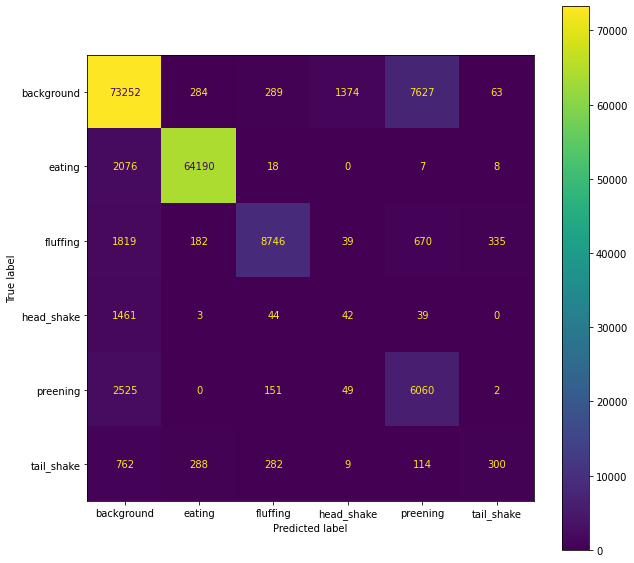

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, x_valid, y_valid, ax=ax) 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


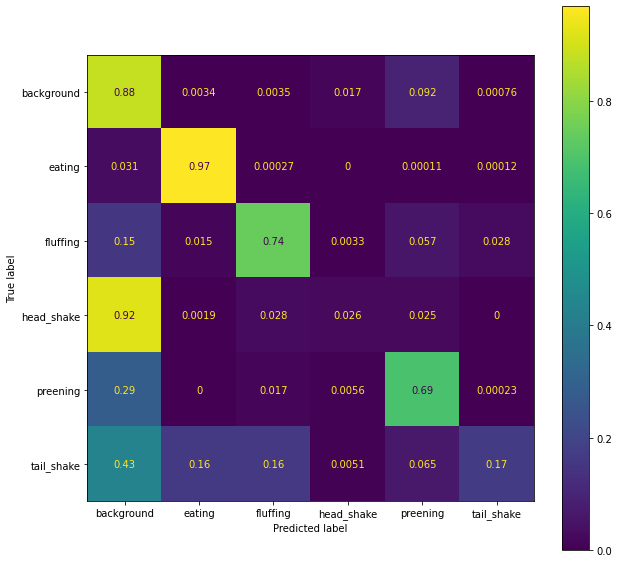

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, x_valid, y_valid, normalize='true', ax=ax) 

In [12]:
clf = RandomForestClassifier(random_state=0, verbose=1)
cv_results = cross_validate(clf, x, y, n_jobs=-1, scoring=['f1_micro', 'f1_weighted', 'f1_macro', 'roc_auc_ovo_weighted', 'roc_auc_ovo'])
print(cv_results.keys())

dict_keys(['fit_time', 'score_time', 'test_f1_micro', 'test_f1_weighted', 'test_f1_macro', 'test_roc_auc_ovo_weighted', 'test_roc_auc_ovo'])


In [17]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_f1_micro,test_f1_weighted,test_f1_macro,test_roc_auc_ovo_weighted,test_roc_auc_ovo
0,1322.733019,10.090977,0.875120,0.865597,0.576413,0.906603,0.880538
1,1237.139006,11.824999,0.816504,0.842856,0.582437,0.926581,0.905365
2,1137.510001,11.740008,0.729663,0.788970,0.521161,0.923030,0.911239
3,1206.631999,11.068015,0.875512,0.877090,0.591777,0.928447,0.907999
4,1157.424991,13.053003,0.868880,0.873396,0.583211,0.923556,0.906910


In [10]:
clf = RandomForestClassifier(random_state=0, verbose=1, class_weight="balanced")
scores = cross_val_score(clf, x, y, n_jobs=-1)
print(scores)

[0.86993819 0.85941309 0.89056669 0.88567897 0.906452  ]


In [ ]:
# TODO: subsample